In [84]:
import numpy as np
import os
from os.path import isfile
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa

import matplotlib.pyplot as plt
%matplotlib inline

### Load training and Validation arrays

In [14]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [15]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']


(6394, 640, 128) (6394, 8)


In [16]:
npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800, 8)


### Check by plotting a Spectogram

Experimental


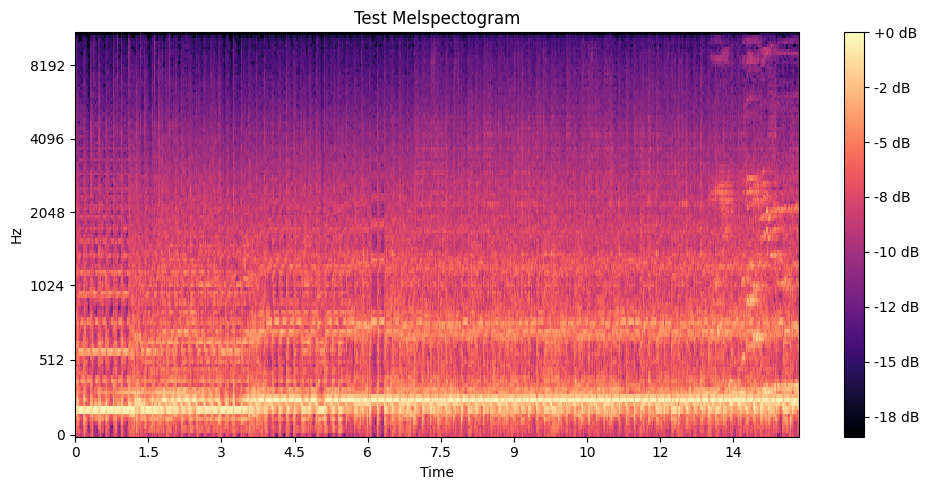

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [17]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### Parallel CNN - RNN Model

In [ ]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [50]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 10
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
#     flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
#     opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [54]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 640
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [70]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [53]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 640, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 638, 128, 16  64          ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 319, 64, 16)  0          ['conv_1[0][0]']                 
 )                                                                        

100/100 [==============================] - 150s 1s/step - loss: 1.9790 - accuracy: 0.2471 - val_loss: 1.8259 - val_accuracy: 0.3137 - lr: 5.0000e-04
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 1.7804 - accuracy: 0.3377WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 156s 2s/step - loss: 1.7804 - accuracy: 0.3377 - val_loss: 1.6946 - val_accuracy: 0.3650 - lr: 5.0000e-04
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.6971 - accuracy: 0.3797WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 149s 1s/step - loss: 1.6971 - accuracy: 0.3797 - val_loss: 1.7153 - val_accuracy: 0.3450 - lr: 5.0000e-04
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 1.6371 - accuracy: 0.4151WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 145s 1s/step - loss: 1.6371 - accuracy: 0.4151 - val_loss: 1.5968 - val_accuracy: 0.3913 - lr: 5.0000e-04
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 1.5935 - accuracy: 0.4241WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 143s 1s/step - loss: 1.5935 - accuracy: 0.4241 - val_loss: 1.6041 - val_accuracy: 0.3825 - lr: 5.0000e-04
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 1.5665 - accuracy: 0.4348WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 144s 1s/step - loss: 1.5665 - accuracy: 0.4348 - val_loss: 1.6085 - val_accuracy: 0.4013 - lr: 5.0000e-04
Epoch 7/10
100/100 [==============================] - ETA: 0s - loss: 1.5444 - accuracy: 0.4475WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 145s 1s/step - loss: 1.5444 - accuracy: 0.4475 - val_loss: 1.6309 - val_accuracy: 0.4075 - lr: 5.0000e-04
Epoch 8/10
100/100 [==============================] - ETA: 0s - loss: 1.5138 - accuracy: 0.4618WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 156s 2s/step - loss: 1.5138 - accuracy: 0.4618 - val_loss: 1.6033 - val_accuracy: 0.4162 - lr: 5.0000e-04
Epoch 9/10
100/100 [==============================] - ETA: 0s - loss: 1.4893 - accuracy: 0.4706WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 167s 2s/step - loss: 1.4893 - accuracy: 0.4706 - val_loss: 1.5087 - val_accuracy: 0.4425 - lr: 5.0000e-04
Epoch 10/10
100/100 [==============================] - ETA: 0s - loss: 1.4647 - accuracy: 0.4747WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 200s 2s/step - loss: 1.4647 - accuracy: 0.4747 - val_loss: 1.5558 - val_accuracy: 0.4175 - lr: 5.0000e-04


In [76]:
model.get_weights()

[array([[[[-0.31001785,  0.21784154, -0.16157454, -0.19730523,
            0.042766  ,  0.03631532, -0.1737747 , -0.1938683 ,
           -0.16308916, -0.15554692,  0.03304065, -0.11533201,
            0.06923297,  0.01633191, -0.11278065, -0.00107178]]],
 
 
        [[[ 0.22746001, -0.1181503 ,  0.25161108,  0.1723953 ,
           -0.257118  ,  0.22942564, -0.18288372,  0.24527933,
           -0.16257505, -0.26471376, -0.20894286,  0.261399  ,
            0.1358459 ,  0.23638263, -0.00037729, -0.16503844]]],
 
 
        [[[ 0.30343336,  0.05454371, -0.06110031,  0.04135564,
           -0.3431224 ,  0.10971203,  0.3056485 , -0.19699407,
           -0.30499044, -0.32573187,  0.147423  ,  0.30372047,
            0.08125779,  0.28675643, -0.13369247,  0.19851105]]]],
       dtype=float32),
 array([ 0.05475572,  0.03993166,  0.03107315,  0.01147157, -0.02786014,
         0.        , -0.01154907,  0.0165363 , -0.00914248, -0.02135582,
        -0.01644679,  0.04321055,  0.        ,  0.       

In [77]:
X_valid.shape

(800, 640, 128, 1, 1)

In [55]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


25/25 [==============================] - 6s 206ms/step
(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.36      0.56      0.44       100
 Experimental       0.33      0.41      0.37       100
         Folk       0.51      0.49      0.50       100
      Hip-Hop       0.51      0.56      0.54       100
 Instrumental       0.29      0.47      0.36       100
International       0.74      0.39      0.51       100
          Pop       0.16      0.08      0.11       100
         Rock       0.78      0.38      0.51       100

     accuracy                           0.42       800
    macro avg       0.46      0.42      0.42       800
 weighted avg       0.46      0.42      0.42       800



In [56]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.4175


### Look at the Test Set

In [25]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [59]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [60]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [61]:
new_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 640, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 638, 128, 16  64          ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 319, 64, 16)  0          ['conv_1[0][0]']                 
 )                                                                                          

In [41]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [42]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000000000000016 0.004623813018385694


In [74]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = new_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

25/25 [==============================] - 6s 234ms/step
(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.43      0.50      0.47       100
 Experimental       0.23      0.32      0.27       100
         Folk       0.20      0.21      0.20       100
      Hip-Hop       0.54      0.82      0.65       100
 Instrumental       0.26      0.44      0.33       100
International       0.40      0.19      0.26       100
          Pop       0.24      0.11      0.15       100
         Rock       0.75      0.18      0.29       100

     accuracy                           0.35       800
    macro avg       0.38      0.35      0.33       800
 weighted avg       0.38      0.35      0.33       800



In [86]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# mat = confusion_matrix(y_true, y_pred)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=dict_genres.keys(),
#             yticklabels=dict_genres.keys())
# plt.xlabel('true label')
# plt.ylabel('predicted label');
# plt.show()

In [79]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.34625


In [87]:
# show_summary_stats(history)

In [81]:
pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
